### LSTM - Input: 'Close/Last', 'Open', 'High', 'Low'

In [1]:
import pandas as pd

# Load the data
data = pd.read_csv('Data_input_1.csv')

# Check for missing values
print(data.isnull().sum())

# Fill missing values or drop rows with missing values
data.fillna(method='ffill', inplace=True)  # forward fill
data.dropna(inplace=True)  # drop any remaining NaNs


Date          0
Close/Last    0
Open          0
High          0
Low           0
dtype: int64


C:\Users\DELL\AppData\Local\Temp\ipykernel_9264\4078876205.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)  # forward fill


In [2]:
data['Date'] = pd.to_datetime(data['Date'])

# Tạo các cột phụ để sắp xếp theo năm, tháng, ngày
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day

# Sắp xếp DataFrame theo năm, sau đó tháng, và cuối cùng là ngày
data.sort_values(['Year', 'Month', 'Day'], inplace=True)

# Xóa các cột phụ nếu không cần thiết
data.drop(columns=['Year', 'Month', 'Day'], inplace=True)

In [3]:
import numpy as np

# Tính toán số lượng dòng cho từng phần
total_rows = len(data)
train_size = int(0.8 * total_rows)
val_size = int(0.1 * total_rows)
test_size = total_rows - train_size - val_size  # Đảm bảo rằng tổng số dòng vẫn bằng total_rows

# Xử lý các giá trị vô hạn hoặc quá lớn
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(how='any', axis=0, inplace=True)

# Chia DataFrame thành các tập huấn luyện, kiểm tra và kiểm định
data_train = data.iloc[:train_size]
data_val = data.iloc[train_size:train_size + val_size]
data_test = data.iloc[train_size + val_size:]

In [4]:
from sklearn.preprocessing import MinMaxScaler

# Chuẩn hóa các cột giá dựa trên tập huấn luyện và áp dụng cho tập kiểm tra và kiểm định
scaler_price = MinMaxScaler(feature_range=(-1, 1))
price_columns = ['Close/Last', 'Open', 'High', 'Low']
data_train_copy=data_train[price_columns]
data_train[price_columns] = scaler_price.fit_transform(data_train[price_columns])
data_val[price_columns] = scaler_price.transform(data_val[price_columns])
data_test_copy=data_test[price_columns]
data_test[price_columns] = scaler_price.transform(data_test[price_columns])

# Chuyển đổi các cột pandas thành mảng NumPy
train_data = data_train[price_columns].values
val_data = data_val[price_columns].values
test_data = data_test[price_columns].values

# Hiển thị kích thước của các tập dữ liệu
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

Training data shape: (1006, 4)
Validation data shape: (125, 4)
Test data shape: (127, 4)


C:\Users\DELL\AppData\Local\Temp\ipykernel_9264\447585929.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train[price_columns] = scaler_price.fit_transform(data_train[price_columns])
C:\Users\DELL\AppData\Local\Temp\ipykernel_9264\447585929.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_val[price_columns] = scaler_price.transform(data_val[price_columns])
C:\Users\DELL\AppData\Local\Temp\ipykernel_9264\447585929.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

In [5]:
# Training data
seq_len = 30
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, 0][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 0][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 0][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)

Training set shape (976, 30, 4) (976,)
Validation set shape (95, 30, 4) (95,)
Testing set shape (97, 30, 4) (97,)


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=30):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]


class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_encoder_layers)
        self.encoder = nn.Linear(input_dim, d_model)
        self.d_model = d_model
        self.decoder = nn.Linear(d_model, 1)

    def forward(self, src):
        src = self.encoder(src) * torch.sqrt(torch.tensor(self.d_model, dtype=torch.float32))
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = self.decoder(output[-1])
        return output

def prepare_data(X_train, y_train, X_val, y_val, X_test, y_test, batch_size):
    train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
    val_data = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
    test_data = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch.permute(1, 0, 2))
            loss = criterion(output.squeeze(), y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                output = model(X_batch.permute(1, 0, 2))
                loss = criterion(output.squeeze(), y_batch)
                val_loss += loss.item()

        print(f'Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}')

def evaluate_model(model, test_loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            output = model(X_batch.permute(1, 0, 2))
            predictions.extend(output.squeeze().tolist())
            actuals.extend(y_batch.tolist())

    return predictions, actuals

In [7]:
input_dim = 4
d_model = 2**6
nhead = 8
num_encoder_layers = 3
dim_feedforward = 512
dropout = 0.1
batch_size = 32
num_epochs = 20
learning_rate = 0.0001

train_loader, val_loader, test_loader = prepare_data(X_train, y_train, X_val, y_val, X_test, y_test, batch_size)
model = TransformerModel(input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)



d:\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1, Train Loss: 0.17179793690241152, Validation Loss: 0.013601486260692278
Epoch 2, Train Loss: 0.022311233855303255, Validation Loss: 0.011047986025611559
Epoch 3, Train Loss: 0.016702800283148404, Validation Loss: 0.0022753182953844466
Epoch 4, Train Loss: 0.01368514487459775, Validation Loss: 0.002052781404927373
Epoch 5, Train Loss: 0.011827661730949917, Validation Loss: 0.002007715830889841
Epoch 6, Train Loss: 0.010758808032879907, Validation Loss: 0.0020012510552381477
Epoch 7, Train Loss: 0.00970476673495385, Validation Loss: 0.0020306132112940154
Epoch 8, Train Loss: 0.010246391528316082, Validation Loss: 0.001964519421259562
Epoch 9, Train Loss: 0.00888246894183178, Validation Loss: 0.004142743069678545
Epoch 10, Train Loss: 0.008248608574391372, Validation Loss: 0.0021886612521484494
Epoch 11, Train Loss: 0.007745973074868802, Validation Loss: 0.002834480566283067
Epoch 12, Train Loss: 0.007873262376374295, Validation Loss: 0.0018151476591204603
Epoch 13, Train Loss: 0.

In [8]:
# Hàm để chuẩn bị dữ liệu cho dự đoán
def prepare_test_data(X_test):
    return torch.tensor(X_test, dtype=torch.float32)

# Dự đoán giá cổ phiếu
def predict_stock_price(model, X_test, scaler_price):
    model.eval()
    with torch.no_grad():
        X_test_tensor = prepare_test_data(X_test)
        predictions = model(X_test_tensor.permute(1, 0, 2))
        predicted_stock_price = predictions.squeeze().numpy()

    # Thêm các cột giá trị giả (zeros) để khớp với hình dạng mà scaler đã được huấn luyện
    predicted_stock_price_extended = np.concatenate((predicted_stock_price.reshape(-1, 1), np.zeros((predicted_stock_price.shape[0], 3))), axis=1)

    # Đảo ngược quá trình chuẩn hóa
    predicted_stock_price_scaled_back = scaler_price.inverse_transform(predicted_stock_price_extended)

    # Loại bỏ các cột giá trị giả
    predicted_stock_price = predicted_stock_price_scaled_back[:, 0]

    return predicted_stock_price

# Thực hiện dự đoán
predicted_stock_price = predict_stock_price(model, X_test, scaler_price)
# print(predicted_stock_price)

In [9]:
predicted_stock_price[0]

9410.675838426949

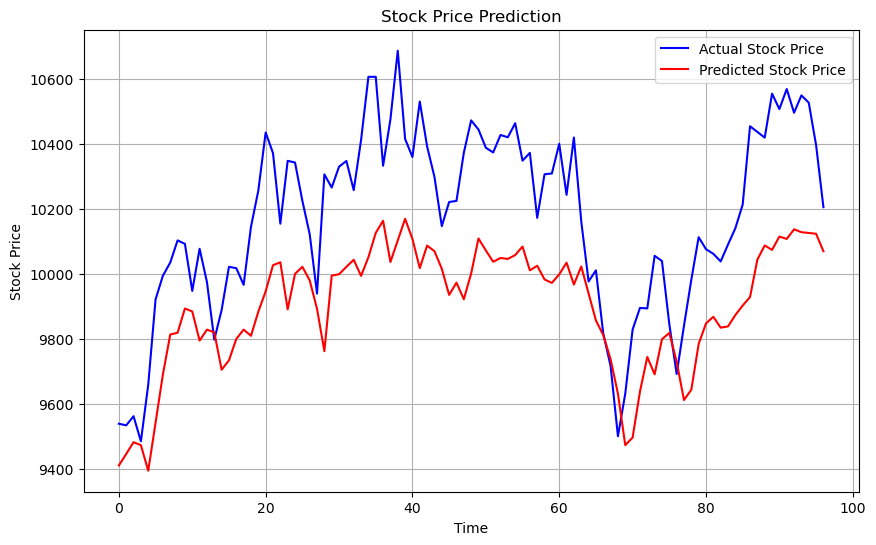

Root Mean Squared Error: 309.12427789834703
Mean Absolute Percentage Error: 0.02692638211158834


In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Get actual prices from the last part of the test set
actual_prices = data_test_copy['Close/Last'].values[seq_len:]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(actual_prices, color='blue', label='Actual Stock Price')
plt.plot(predicted_stock_price, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

# Calculate RMSE
rmse = mean_squared_error(actual_prices, predicted_stock_price, squared=False)
print(f"Root Mean Squared Error: {rmse}")

mape = mean_absolute_percentage_error(actual_prices, predicted_stock_price)
print(f"Mean Absolute Percentage Error: {mape}")


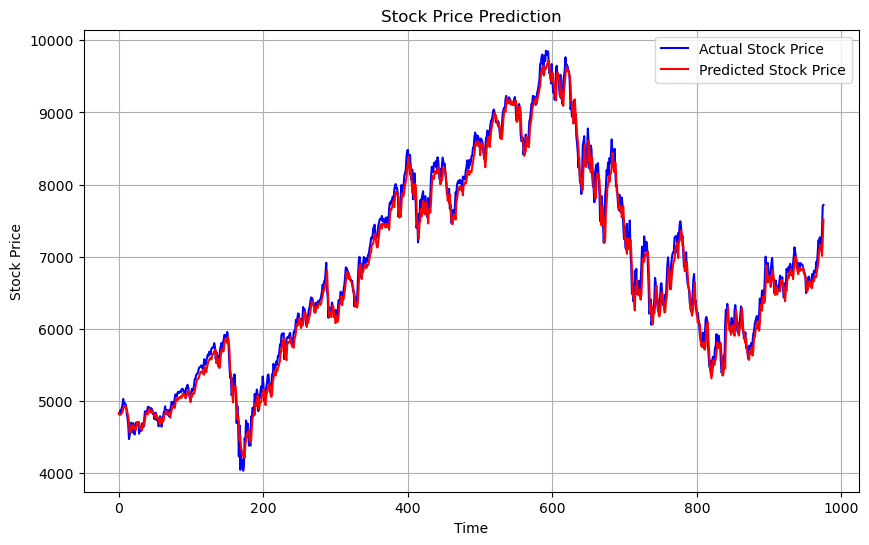

In [11]:
predicted_stock_price_train = predict_stock_price(model, X_train, scaler_price)
actual_prices_train = data_train_copy['Close/Last'].values[seq_len:]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(actual_prices_train, color='blue', label='Actual Stock Price')
plt.plot(predicted_stock_price_train, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
torch.save(model.state_dict(), 'TransformerMain.pth')
import joblib
joblib.dump(scaler_price, 'scaler_price_maintransformer.pkl')
np.save('X_test_maintransformer.npy', X_test)